#     Gaussian Process Regression

Let's begin with importing the required libraries:

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    WhiteKernel,
    ExpSineSquared
)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm

# for saving data files
import pandas as pd

In [81]:
# Initialize X/Y with hand/end-eff data, respectively, from first run
set_num=1 
run = 1

# Uncomment the next line when running on Ubuntu, the line following if running on Windows
# data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
print(sorted(data.files))

endpt = -150 # Empirically determined end of data (cutting off trailing ends)
stepsize = 10
x = np.hstack((data['hand_pos_aligned'][0:endpt:stepsize], data['hand_rot_aligned'][0:endpt:stepsize]))
y = data['joint_data_aligned'][0:endpt:stepsize]

# Concatenate data for the rest of the runs, leaving one out to be the test set
skipval = 0 # Identify the run that will serve as the test dataset

for set_num in range(0,9):
#     print("set_num = "+str(set_num))
    for run in range (1,11):
        if set_num==skipval : 
            continue
        else :
#             print("run="+str(run))
#             data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
            data = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
            x_temp = np.hstack((data['hand_pos_aligned'][0:endpt:stepsize], data['hand_pos_aligned'][0:endpt:stepsize]))
            y_temp = data['joint_data_aligned'][0:endpt:stepsize]
            x = np.vstack((x,x_temp))
            y = np.vstack((y,y_temp))

['end_eff_data', 'end_eff_pos_aligned', 'end_eff_rot_aligned', 'hand_data', 'hand_pos_aligned', 'hand_rot_aligned', 'joint_data_aligned', 'run', 'set_num', 'time_URDF_aligned', 'time_hand_aligned', 'time_ja_aligned', 'warp_path']


In [82]:
set_num=skipval
run=4
# data = np.load("../NonAnthroHands_User_Study/data/positions/positions_"+str(set_num)+"_data/DTW_processed_data/data_"+str(set_num)+"_"+str(run)+".npz")
data_test = np.load("..\\NonAnthroHands_User_Study\\data\\positions\\positions_"+str(set_num)+"_data\\DTW_processed_data\\data_"+str(set_num)+"_"+str(run)+".npz")
x_star = np.hstack((data_test['hand_pos_aligned'][0:endpt:stepsize], data_test['hand_rot_aligned'][0:endpt:stepsize]))
y_test = data_test['joint_data_aligned'][0:endpt:stepsize]

In [83]:
# Construction of Sklearn's Regression and Selection of the Kernel
kernel = RBF(1,(.5,10))
gp_regressor = GaussianProcessRegressor(kernel=kernel, alpha=1e-2, normalize_y=True)
gp_regressor.fit(x,y)
print(f"RBF Lengthscale: {gp_regressor.kernel_}")

y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

df = pd.DataFrame(y_pred_mean)
df.to_csv('trained_endeff_mean.csv')
df = pd.DataFrame(y_pred_std)
df.to_csv('trained_endeff_std.csv')


RBF Lengthscale: RBF(length_scale=0.5)


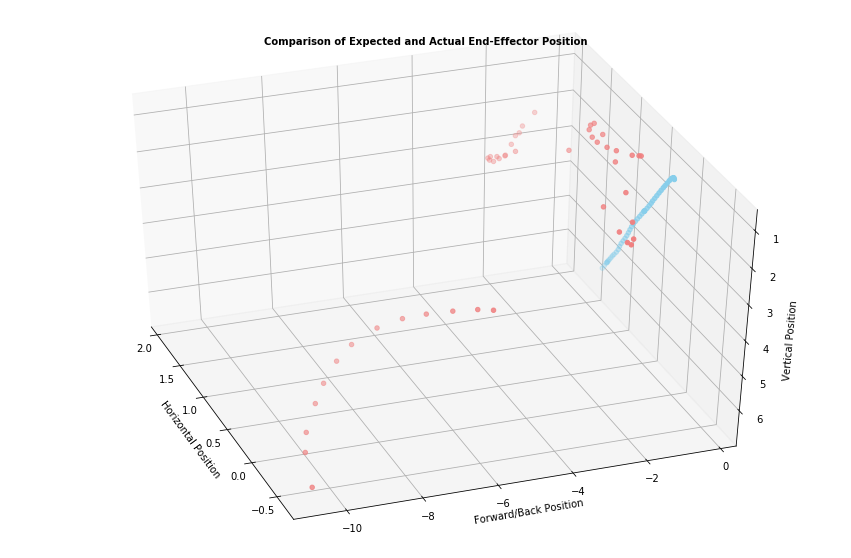

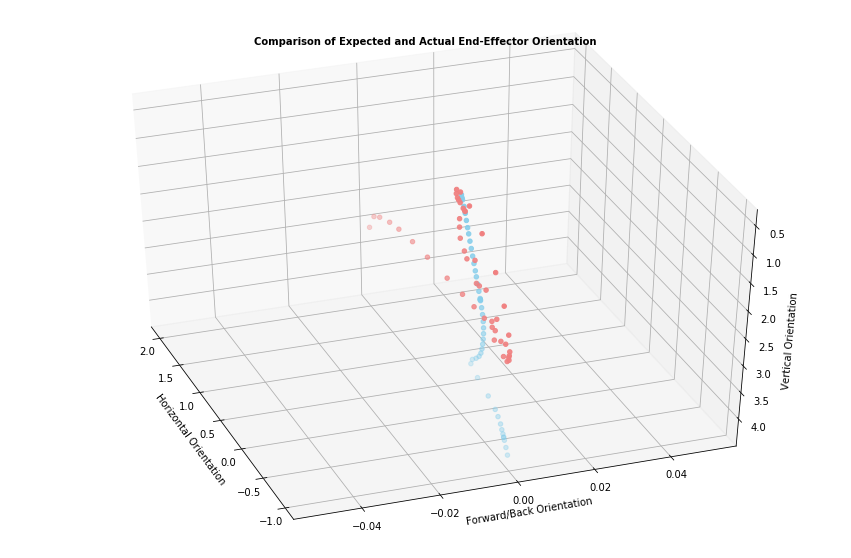

In [84]:
# Plotting the Predicted Values
labels=('Position','Orientation')

y_pred_mean, y_pred_std = gp_regressor.predict(x_star, return_std=True)

for i in range(2):
    fig, ax = plt.subplots(figsize=(15, 10))

    # Show the border and axes ticks
    fig.patch.set_visible(True)
    ax = plt.axes(projection='3d')
    ax.axis('on')
    ax.view_init(-140, 20)
    ax.scatter(y_test[:].T[3*i+0]    , -y_test[:].T[3*i+2]      , y_test[:].T[3*i+1],c='skyblue')   #, c=time_hand_aligned/max(time_hand_aligned), cmap='Blues', label='Hand orientation')
    ax.scatter(y_pred_mean[:].T[3*i+0], -y_pred_mean[:].T[3*i+2], y_pred_mean[:].T[3*i+1],c='lightcoral') #, c=time_URDF_aligned/max(time_URDF_aligned), cmap='Reds', label='End-effector orientation')
    ax.scatter(y_pred_mean[:].T[3*i+0], -y_pred_mean[:].T[3*i+2], y_pred_mean[:].T[3*i+1],c='lightcoral', alpha = 0.05, s=y_pred_std)
    #     ax.legend([(prediction, error)], ['merged'])
    

# for [map_x, map_y] in warp_path: 
#     ax.plot3D([y_pred_mean[map_x].T[3*i+0], y_test[map_y].T[3*i+0]], \
#               [-y_pred_mean[map_x].T[3*i+2], -y_test[map_y].T[3*i+2]],\
#               [y_pred_mean[map_x].T[3*i+1], y_test[map_y].T[3*i+1]], \
#               '--k', linewidth=0.2)

    ax.set_xlabel('Horizontal '+labels[i])
    ax.set_ylabel('Forward/Back '+labels[i])
    ax.set_zlabel('Vertical '+labels[i])
    ax.set_title("Comparison of Expected and Actual End-Effector "+labels[i], fontsize=10, fontweight="bold")

    plt.savefig('GPR_output_'+labels[i]+'.png')
    
    plt.show()
    plt.close('all')



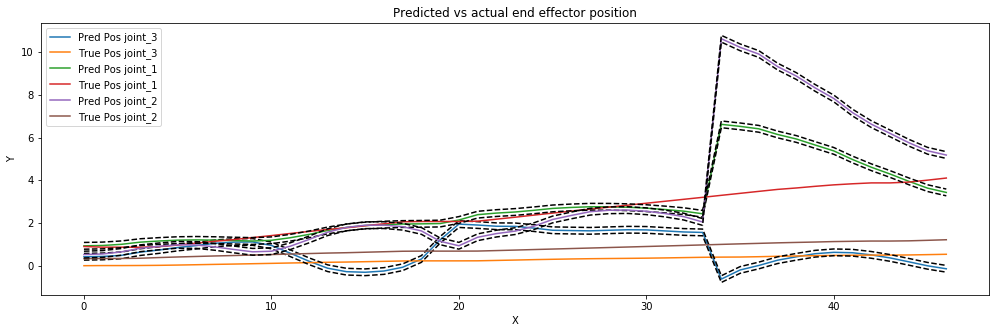

In [89]:
f = plt.figure(figsize=[17.0, 5.0])

ax = f.add_subplot(111)
# labels = ('X','Y','Z')
labels = ('joint_1','joint_2','joint_3')
errorlabels = ('One STD')
it=0
for i in range(0+it*3,3+it*3):
    ax.plot(y_pred_mean[:].T[i],label='Pred Pos '+labels[i-it*3-1])
    ax.plot(y_test[:].T[i],label='True Pos '+labels[i-it*3-1])
#     ax.plot(y_pred_std[:].T[i],linewidth=)
    if i==3:
        ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std.T[i], 'k--',label='One STD')
    else:
        ax.plot(np.squeeze(y_pred_mean.T[i]) + y_pred_std.T[i], 'k--')
    ax.plot(np.squeeze(y_pred_mean.T[i]) - y_pred_std.T[i], 'k--')
ax.set_xlabel('X');
ax.set_ylabel('Y');
ax.set_title('Predicted vs actual end effector position');
ax.legend();
plt.savefig('Error.png')
plt.show()
plt.close('all')

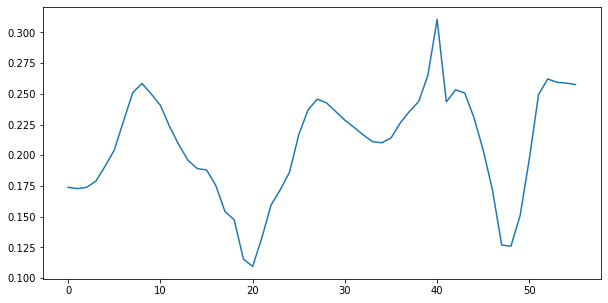

In [45]:
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
ax.plot(y_pred_std);


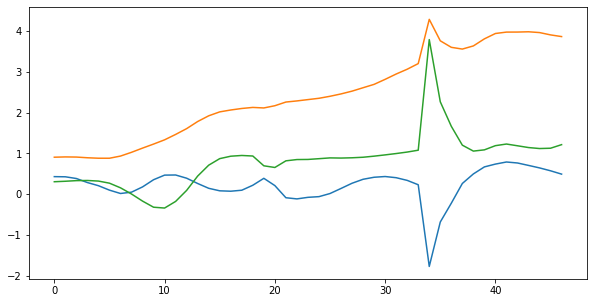

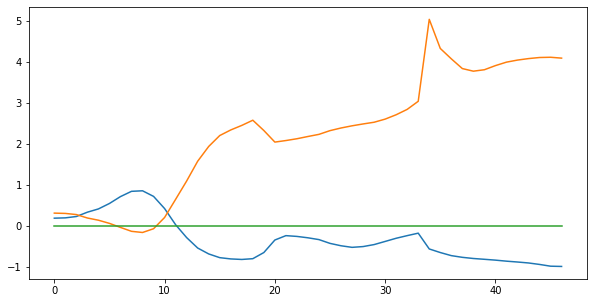

In [75]:
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_pred_mean[:,0])
ax.plot(y_pred_mean[:,1])
ax.plot(y_pred_mean[:,2])
plt.show()
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_pred_mean[:,3])
ax.plot(y_pred_mean[:,4])
ax.plot(y_pred_mean[:,5])

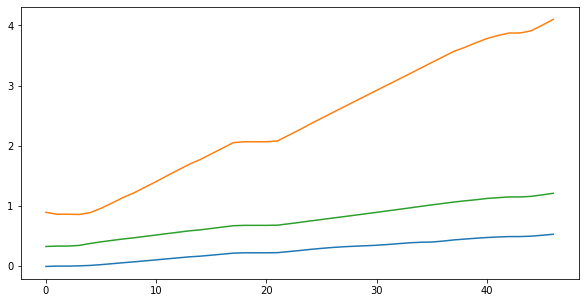

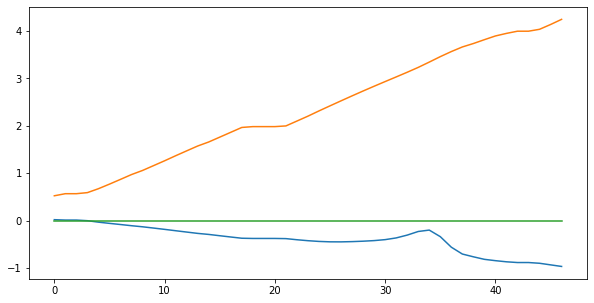

In [76]:
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_test[:,0])
ax.plot(y_test[:,1])
ax.plot(y_test[:,2])
plt.show()
f = plt.figure(figsize=[10.0, 5.0])
ax = f.add_subplot(111)
# ax = plt.axes(projection='3d')
ax.plot(y_test[:,3])
ax.plot(y_test[:,4])
ax.plot(y_test[:,5])

In [48]:
y_test.shape

(56, 6)